<a href="https://colab.research.google.com/github/JaohBlack/Analytics/blob/main/Customer%20segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data is in this link.
https://raw.githubusercontent.com/pallavrouth/MarketingAnalytics/refs/heads/main/datasets/churn_practice.csv

This data is from a bank and has information on various customer attributes and their transaction characteristics. Here is the data description -
- `RowNumber`: corresponds to the record (row) number and has no effect on the output.
- `CustomerId`: contains random values and has no effect on customer leaving the bank.
- `Surname`: the surname of a customer has no impact on their decision to leave the bank.
- `CreditScore`: can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- `Geography`: a customer’s location can affect their decision to leave the bank.
- `Gender`: it’s interesting to explore whether gender plays a role in a customer leaving the bank.
- `Age`: this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
- `Tenure`: refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
- `Balance`: also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank - compared to those with lower balances.
- `NumOfProducts`: refers to the number of products that a customer has purchased through the bank.
- `HasCrCard`: denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
- `IsActiveMember`: active customers are less likely to leave the bank.
- `EstimatedSalary`: as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
- `Exited`: whether or not the customer left the bank.

The goal is to **generate clusters** based on transaction behavior and then **evaluate the quality of the clusters**. Finally, you are required to **assess whether these clusters can be predicted** using readily available demographic variables. Follow the instructions below to complete these tasks and include the appropriate code.

1. Import the dataset. Name the imported dataset as `data`.

2. The next step is to clean the dataset `data`:
    - Check if there are any missing values. If yes, delete the rows.
    - Check if there are any duplicated rows. If yes, delete the duplicates.
    - Check the distinct values for gender and geography.
    - Rename all columns using the dictionary `rename_cols` below.
    - Create a variable `male` which equals 1 if gender is male. Create a variable `france` which equals 1 if geography is `france` and another variable `germany` which equals 1 if geography is `germany` (Hint: Use `np.where` from `numpy` to do this).
    - Name this cleaned dataset `data_clean`.

3. Perform cluster analysis
    - Use the following variables: `credit_score`, `balance`, `num_products`, `tenure`. Scale the data. Call this `scaled_features`.
    - Using `scaled_features` check for the number of clusters:
        - Use a dendogram to figure out the number of clusters k.
        - Use within cluster sum of squares (WSS) to create an elbow plot. Use the `wss_calculation` function from class materials to compute WSS. When using the function `wss_calculation` use `AgglomerativeClustering` function instead of `KMeans`. Once you calculate WSS, generate the WSS versus cluster (k) plot. Comment on if the "elbow" coincides with the number of clusters k, as seen from the dendogram.
    - Once you determine the number of clusters k, perform `KMeans` clustering.
    - Get the cluster labels
    - Add this label to the `data_clean` as a new column called `segment`. Call this data `data_segments`.
    - Generate average `credit_score`, `balance`, `num_products`, `tenure` by each segment. Comment on whether you notice any differences between the clusters? Name the clusters appropriately. Use your imagination here.

4. Check cluster viability: Check for the total number of credit card holders and active members in each segment. Comment on which segment is the best.

5. Check if these cluster labels can be predicted using easily available customer variables: `male`, `age`, `est_salary`, `france`, `germany`.
    - In order to check this, perform linear discriminant analysis (LDA) using these variables to predict `segment`.
    - Calculate the accuracy score between the predictions from the LDA model and segments created by KMeans. Comment on if you think these variables are sufficiently good at predicting cluster membership.


In [ ]:
rename_cols = {
    "CustomerID" : "customer_id",
    "Surname" : "surname",
    "CreditScore" : "credit_score",
    "Geography" : "geography",
    "Gender" : "gender",
    "Age" : "age",
    "Tenure" : "tenure",
    "Balance" : "balance",
    "NumOfProducts" : "num_products",
    "HasCrCard" : "has_credit",
    "IsActiveMember" : "is_active",
    "EstimatedSalary" : "est_salary",
    "Exited" : "exited"
}

In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv("https://raw.githubusercontent.com/pallavrouth/MarketingAnalytics/refs/heads/main/datasets/churn_practice.csv")

In [ ]:
print(data.isnull().sum( ))
data = data.dropna()
print(data.duplicated().sum( ))
data = data.drop_duplicates(keep = "last")
print(data.Gender.unique( ))
print(data.Geography.unique( ))
data = data.rename(columns = rename_cols)
data = data.assign(
    male=lambda d: np.where(d.gender == 'Male', 1, 0),
    france=lambda d: np.where(d.geography == 'France', 1, 0),
    germany=lambda d: np.where(d.geography == 'Germany', 1, 0)
)
data_clean = data

RowNumber           0
CustomerId          0
Surname             0
CreditScore        93
Geography           0
Gender              0
Age                 0
Tenure              0
Balance             0
NumOfProducts       0
HasCrCard           0
IsActiveMember      0
EstimatedSalary     0
Exited              0
dtype: int64
4
['Female' 'Male']
['France' 'Spain' 'Germany']


In [ ]:
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from plotnine import (
    ggplot,
    aes,
    geom_point,
    geom_line
)
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

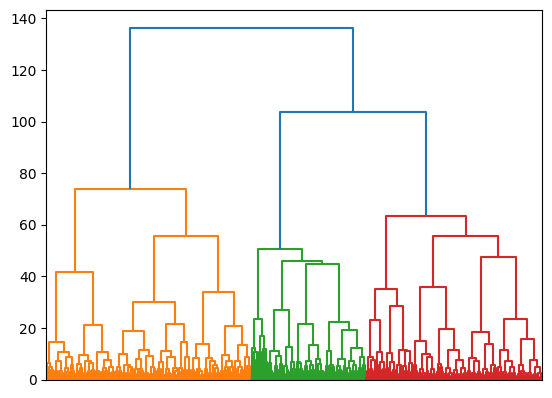

In [ ]:
req_cols = ["credit_score", "balance", "num_products", "tenure"]
clustering_features = data_clean.loc[:, req_cols]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

linkage_data = linkage(scaled_features, method='ward', metric='euclidean')
dendrogram(linkage_data, no_labels=True)
plt.show()

In [ ]:
def wss_calculation(K, data):
    WSS = []
    for k in range(1, K+1):
        cluster = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = cluster.fit_predict(data)
        wss = 0
        for i in range(k):
            cluster_points = data[labels == i]
            cluster_mean = np.mean(cluster_points, axis=0)
            wss += np.sum((cluster_points - cluster_mean) ** 2)
        WSS.append(wss)
    return WSS

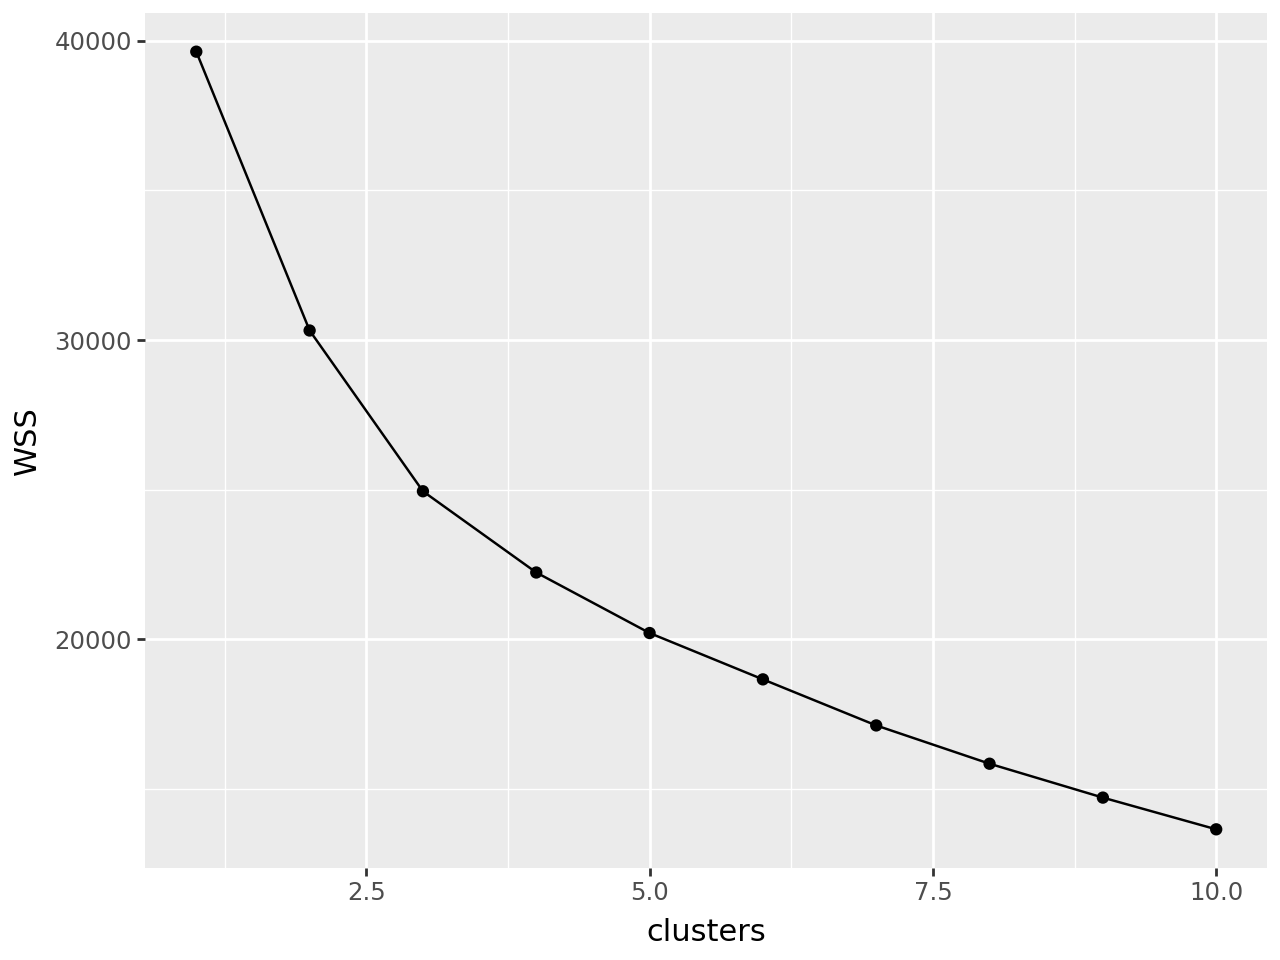

In [ ]:
WSS = wss_calculation(10, scaled_features)
plot_data = pd.DataFrame({"clusters": range(1, 11), "WSS": WSS})
(
    ggplot(plot_data, aes(x="clusters", y="WSS"))
    + geom_point()
    + geom_line()
).show()


In [ ]:
 # My number of clusters in the dendogram corresponds to the elbow.
kmeans_model = KMeans(n_clusters=4, random_state=1)
data_clean['segment'] = kmeans_model.fit_predict(scaled_features)
data_segments = data_clean.copy()

average_values = data_segments.groupby('segment')[['credit_score', 'balance', 'num_products', 'tenure']].mean()
print(average_values)

         credit_score        balance  num_products    tenure
segment                                                     
0          722.292807   28831.709828      1.968910  3.415777
1          583.352011   19791.112897      1.892454  6.658382
2          624.132273  115630.641550      1.200940  2.400072
3          675.036436  119578.115180      1.229437  7.539322


Segment 0 consists of customers with excellent credit scores. These individuals are financially responsible and likely to be interested in premium banking products. Although they are relatively new customers, their strong creditworthiness makes them ideal candidates for targeted premium services. I can call them "Creditworthy Newcomers.

Segment 1includes customers who have been with the bank for a long time. Despite having lower credit scores, their long-term relationship with the bank indicates a steady and reliable customer base. These customers might benefit from loyalty programs and retention strategies to maintain their engagement. I can name them "Longterm Loyal Spenders".

Segment 2 stands out due to their significant spending power. These customers have high balances, indicating they are high-value clients. Although they have a shorter tenure and fewer products, their substantial balances make them ideal for targeted marketing campaigns and premium offers. I can call them "High Networth Newcomers.

Finally, segment 3 comprises customers with high balances and the longest tenure. These individuals have strong, long-term relationships with the bank and are likely to be loyal and valuable over time. Their high credit scores and moderate number of products suggest they are well-established and financially stable. They can be called "Wealthy Longterm Clients".

In [ ]:
#4
(
    data_segments
    .groupby(['segment'])
    .agg(
        total_credit_card_holders=('has_credit', 'sum'),
        total_active_members=('is_active', 'sum')
    )
)


,total_credit_card_holders,total_active_members
segment,,
0,1509,1140
1,1604,1109
2,1911,1474
3,1974,1370


Although Segment 3 has slightly more credit card holders (1974 against 1911), Segment 2 has the highest number of active members (1474), making Segment 2 the most viable segment. High active membership indicates better engagement, which is often a stronger predictor of customer loyalty and long-term value.
Segment 3 has more credit card holders, and a slightly lower number of active members (1370) suggests slightly less engagement compared to Segment 2, making it the second-best.

In [ ]:
#5
cols_used = ['male', 'age', 'est_salary', 'france', 'germany']
descriptors = data_segments.loc[:,cols_used]
segment = data_segments['segment']

lda = LinearDiscriminantAnalysis()
lda.fit(descriptors, segment)
predicted_segment = lda.predict(descriptors)

lda_segmentation = ( data_segments).assign(predicted_segment = predicted_segment)
# display only the segment and predicted_segment columns
lda_segmentation.loc[:,["segment","predicted_segment"]]

accuracy = accuracy_score(segment, predicted_segment)
print(f'The accuracy of the LDA model and segment: {accuracy * 100:.2f}%')

The accuracy of the LDA model and segment: 30.49%


The result of 30.49% accuracy is low, this means that the customer variables (male, age, est_salary, france, germany) may not be sufficient to reliably predict the cluster labels created by KMeans. We might consider adding some more variables.